In [ ]:
# Charts - with titles
import os
import pandas as pd
from plotnine import *
from plotnine.ggplot import save_as_pdf_pages

# Create 'plots' directory
plot_dir = "plots"
os.makedirs(plot_dir, exist_ok=True)

# Load dataset
df_raw = pd.read_csv("combined_data_final_v3.csv")

# Remove price_kbbValue > 80,000
df = df_raw[df_raw["price_kbbValue"] <= 80000].copy()

# Remove extra spaces in state names
df["state"] = df["state"].str.strip()

# Filter for selected states
selected_states = ["California", "Massachusetts", "Oregon", "Florida", "Georgia", "Texas"]
df = df[df["state"].isin(selected_states)]

# Remove fuelType = "CNG"
df = df[df["fuelType"] != "CNG"]

# Fill missing drivetrain values with "Not Available"
df["drivetrain"].fillna("Not Available", inplace=True)

# Fill missing engine_size with 0
df["engine_size"].fillna(0, inplace=True)

# Convert categorical variables
df["source"] = df["source"].replace({"CV": "Fetched", "TC": "Imputed"}).astype("category")

# Compute Age (Keep age=0 vehicles, remove only when used)
df["age"] = 2025 - df["year"]

# Compute Annual Mileage and Remove Outliers Above 50,000 miles/year
df["annual_mileage"] = df["mileage"] / df["age"]
df = df[df["annual_mileage"] <= 50000]

# Define Fuel Type Order & Colors
fuel_order = ["Electric", "Plug-In Hybrid", "Hydrogen", "Hybrid", "Gas", "Diesel"]
fuel_colors = {
    "Electric": "#1f77b4",
    "Plug-In Hybrid": "#aec7e8",
    "Hydrogen": "#2ca02c",
    "Hybrid": "#7f7f7f",
    "Gas": "#c7c7c7",
    "Diesel": "#d9d9d9"
}

# Define Drivetrain Order
drivetrain_order = ["4WD", "AWD", "FWD", "RWD"]

# Common theme for white background
plot_theme = theme(
    panel_background=element_rect(fill="white"),
    plot_background=element_rect(fill="white"),
    legend_title=element_blank(),
    axis_text_x=element_text(size=8, angle=45, hjust=1),
    axis_text_y=element_text(size=8)
)

### **Scatter Plots**
scatter_age_price = (
    ggplot(df[df["age"] > 0].dropna(subset=["age", "price_total"]), aes(x="age", y="price_total")) +
    geom_point(alpha=0.5) +
    labs(title="Vehicle Age vs. Price", x="Age (years)", y="Price (USD)") +
    theme_minimal() + plot_theme
)

scatter_price_fuelType = (
    ggplot(df.dropna(subset=["fuelType", "price_total"]), aes(x="fuelType", y="price_total")) +
    geom_jitter(alpha=0.5) +
    labs(title="Price Distribution by Fuel Type", x="Fuel Type", y="Price (USD)") +
    theme_minimal() + plot_theme
)

scatter_price_kbb = (
    ggplot(df.dropna(subset=["price_total", "price_kbbValue"]), aes(x="price_kbbValue", y="price_total", color="source")) +
    geom_jitter(alpha=0.5, width=500, height=500) +
    scale_color_manual(values={"Imputed": "red", "Fetched": "blue"}) +
    labs(title="Price vs. KBB Value", x="KBB Value (USD)", y="Price (USD)") +
    theme_minimal() + plot_theme
)

### **Faceted Scatter Plot: Age vs. Price by Fuel Type (With Trendline)**
scatter_age_price_facet = (
    ggplot(df[df["age"] > 0].dropna(subset=["age", "price_total", "fuelType"]), aes(x="age", y="price_total")) +
    geom_point(alpha=0.5) +
    geom_smooth(method="lm", color="blue", linetype="dashed") +  # Trendline
    facet_wrap("~fuelType") +
    labs(title="Vehicle Age vs. Price by Fuel Type", x="Age (years)", y="Price (USD)") +
    theme_minimal() + plot_theme
)

### **Box + Violin Plots**
def create_box_violin_plot(x_col, y_col, df, title, x_label, y_label, filename):
    plot = (
        ggplot(df.dropna(subset=[x_col, y_col]), aes(x=x_col, y=y_col)) +
        geom_violin(alpha=0.5) +  # Violin plot for density
        geom_boxplot(width=0.2, outlier_size=1) +  # Box plot overlaid
        labs(title=title, x=x_label, y=y_label) +
        theme_minimal() + plot_theme
    )
    plot.save(os.path.join(plot_dir, filename), dpi=300)
    return plot

box_violin_annual_mileage = create_box_violin_plot("state", "annual_mileage", df, "Annual Mileage by State", "State", "Annual Mileage (miles/year)", "box_violin_annual_mileage.png")
box_violin_price_fuel = create_box_violin_plot("fuelType", "price_total", df, "Price Distribution by Fuel Type", "Fuel Type", "Price (USD)", "box_violin_price_fuel.png")

### **Bar Charts**
def create_percentage_bar_chart(group_col, title, filename, filter_year=None, exclude_na=True, category_order=None, color_map=None):
    df_filtered = df.copy()
    if filter_year:
        df_filtered = df_filtered[df_filtered["year"] >= filter_year]

    if exclude_na and group_col == "drivetrain":
        df_filtered = df_filtered[df_filtered["drivetrain"] != "Not Available"]

    df_grouped = df_filtered.groupby(["state", group_col]).size().reset_index(name="count")
    total_counts = df_filtered.groupby("state").size().reset_index(name="total")
    
    df_grouped = df_grouped.merge(total_counts, on="state")
    df_grouped["percentage"] = (df_grouped["count"] / df_grouped["total"]) * 100  

    if category_order:
        df_grouped[group_col] = pd.Categorical(df_grouped[group_col], categories=category_order, ordered=True)

    chart = ggplot(df_grouped, aes(x="state", y="percentage", fill=group_col)) + \
        geom_bar(stat="identity", position="stack") + \
        (scale_fill_manual(values=color_map) if color_map else scale_fill_hue()) + \
        labs(title=title, x="State", y="Percentage of Vehicles") + \
        theme_minimal() + plot_theme

    chart.save(os.path.join(plot_dir, filename), dpi=300)
    return chart

bar_fuelType_2023 = create_percentage_bar_chart("fuelType", "Proportion of Vehicles by Fuel Type (2023 Onwards)", "bar_fuelType_2023.png", filter_year=2023, category_order=fuel_order, color_map=fuel_colors)
bar_fuelType_2019 = create_percentage_bar_chart("fuelType", "Proportion of Vehicles by Fuel Type (2019 Onwards)", "bar_fuelType_2019.png", filter_year=2019, category_order=fuel_order, color_map=fuel_colors)
bar_drivetrain = create_percentage_bar_chart("drivetrain", "Proportion of Vehicles by Drivetrain", "bar_drivetrain.png", category_order=drivetrain_order)

save_as_pdf_pages([scatter_age_price, scatter_price_fuelType, scatter_price_kbb, scatter_age_price_facet, box_violin_annual_mileage, box_violin_price_fuel, bar_fuelType_2023, bar_fuelType_2019, bar_drivetrain], filename=os.path.join(plot_dir, "all_plots.pdf"))

print("All plots saved successfully!")

/var/folders/tc/7rffx3s51231_4kfgpv0wt2m0000gn/T/ipykernel_34573/227267888.py:12: DtypeWarning: Columns (0,4,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
/var/folders/tc/7rffx3s51231_4kfgpv0wt2m0000gn/T/ipykernel_34573/227267888.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/var/folders/tc/7rffx3s51231_4kfgpv0wt2m0000gn/T/ipykernel_34573/227267888.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The 

In [13]:
# Plots without titles
import os
import pandas as pd
from plotnine import *
from plotnine.ggplot import save_as_pdf_pages

# Create 'plots' directory
plot_dir = "plots"
os.makedirs(plot_dir, exist_ok=True)

# Load dataset
df_raw = pd.read_csv("combined_data_final_v3.csv")

# Remove price_kbbValue > 80,000
df = df_raw[df_raw["price_kbbValue"] <= 80000].copy()

# Remove extra spaces in state names
df["state"] = df["state"].str.strip()

# Filter for selected states
selected_states = ["California", "Massachusetts", "Oregon", "Florida", "Georgia", "Texas"]
df = df[df["state"].isin(selected_states)]

# Remove fuelType = "CNG"
df = df[df["fuelType"] != "CNG"]

# Fill missing drivetrain values with "Not Available"
df["drivetrain"].fillna("Not Available", inplace=True)

# Fill missing engine_size with 0
df["engine_size"].fillna(0, inplace=True)

# Convert categorical variables
df["source"] = df["source"].replace({"CV": "Fetched", "TC": "Imputed"}).astype("category")

# Compute Age (Keep age=0 vehicles, remove only when used)
df["age"] = 2025 - df["year"]

# Compute Annual Mileage and Remove Outliers Above 50,000 miles/year
df["annual_mileage"] = df["mileage"] / df["age"]
df = df[df["annual_mileage"] <= 50000]

# Define Fuel Type Order & Colors
fuel_order = ["Electric", "Plug-In Hybrid", "Hydrogen", "Hybrid", "Gas", "Diesel"]
fuel_colors = {
    "Electric": "#1f77b4",
    "Plug-In Hybrid": "#aec7e8",
    "Hydrogen": "#2ca02c",
    "Hybrid": "#7f7f7f",
    "Gas": "#c7c7c7",
    "Diesel": "#d9d9d9"
}

# Define Drivetrain Order
drivetrain_order = ["4WD", "AWD", "FWD", "RWD"]

# Common theme (No Titles)
plot_theme = theme(
    panel_background=element_rect(fill="white"),
    plot_background=element_rect(fill="white"),
    legend_title=element_blank(),
    axis_text_x=element_text(size=12, angle=0, hjust=0.5),
    axis_text_y=element_text(size=12, angle=0, hjust=1),
    plot_title=element_blank()
)

### **Scatter Plots**
scatter_age_price = (
    ggplot(df[df["age"] > 0].dropna(subset=["age", "price_total"]), aes(x="age", y="price_total")) +
    geom_point(alpha=0.5) +
    labs(x="Age (years)", y="Price (USD)") +
    theme_minimal() + plot_theme
)

scatter_price_fuelType = (
    ggplot(df.dropna(subset=["fuelType", "price_total"]), aes(x="fuelType", y="price_total")) +
    geom_jitter(alpha=0.5) +
    labs(x="Fuel Type", y="Price (USD)") +
    theme_minimal() + plot_theme
)

scatter_price_kbb = (
    ggplot(df.dropna(subset=["price_total", "price_kbbValue"]), aes(x="price_kbbValue", y="price_total", color="source")) +
    geom_jitter(alpha=0.2, width=500, height=500) +
    scale_color_manual(values={"Imputed": "red", "Fetched": "blue"}) +
    labs(x="KBB Value (USD)", y="Price (USD)") +
    theme_minimal() + plot_theme
)

### **Faceted Scatter Plot**
scatter_age_price_facet = (
    ggplot(df[df["age"] > 0].dropna(subset=["age", "price_total", "fuelType"]), aes(x="age", y="price_total")) +
    geom_point(alpha=0.5) +
    geom_smooth(method="lm", color="blue", linetype="dashed") +  
    facet_wrap("~fuelType") +
    labs(x="Age (years)", y="Price (USD)") +
    theme_minimal() + plot_theme
)

### **Box + Violin Plots**
def create_box_violin_plot(x_col, y_col, df, x_label, y_label, filename):
    plot = (
        ggplot(df.dropna(subset=[x_col, y_col]), aes(x=x_col, y=y_col)) +
        geom_violin(alpha=0.5) +  
        geom_boxplot(width=0.2, outlier_size=1) +  
        labs(x=x_label, y=y_label) +
        theme_minimal() + plot_theme
    )
    plot.save(os.path.join(plot_dir, filename), dpi=300)
    return plot

box_violin_annual_mileage = create_box_violin_plot("state", "annual_mileage", df, "State", "Annual Mileage (miles/year)", "box_violin_annual_mileage.png")
box_violin_price_fuel = create_box_violin_plot("fuelType", "price_total", df, "Fuel Type", "Price (USD)", "box_violin_price_fuel.png")

### **Bar Charts**
def create_percentage_bar_chart(group_col, filename, filter_year=None, exclude_na=True, category_order=None, color_map=None):
    df_filtered = df.copy()
    if filter_year:
        df_filtered = df_filtered[df_filtered["year"] >= filter_year]

    if exclude_na and group_col == "drivetrain":
        df_filtered = df_filtered[df_filtered["drivetrain"] != "Not Available"]

    df_grouped = df_filtered.groupby(["state", group_col]).size().reset_index(name="count")
    total_counts = df_filtered.groupby("state").size().reset_index(name="total")
    
    df_grouped = df_grouped.merge(total_counts, on="state")
    df_grouped["percentage"] = (df_grouped["count"] / df_grouped["total"]) * 100  

    if category_order:
        df_grouped[group_col] = pd.Categorical(df_grouped[group_col], categories=category_order, ordered=True)

    chart = ggplot(df_grouped, aes(x="state", y="percentage", fill=group_col)) + \
        geom_bar(stat="identity", position="stack") + \
        (scale_fill_manual(values=color_map) if color_map else scale_fill_hue()) + \
        labs(x="State", y="Percentage of Vehicles") + \
        theme_minimal() + plot_theme

    chart.save(os.path.join(plot_dir, filename), dpi=300)
    return chart

bar_fuelType_2023 = create_percentage_bar_chart("fuelType", "bar_fuelType_2023.png", filter_year=2023, category_order=fuel_order, color_map=fuel_colors)
bar_fuelType_2019 = create_percentage_bar_chart("fuelType", "bar_fuelType_2019.png", filter_year=2019, category_order=fuel_order, color_map=fuel_colors)
bar_drivetrain = create_percentage_bar_chart("drivetrain", "bar_drivetrain.png", category_order=drivetrain_order)

# Save all plots in a single PDF
save_as_pdf_pages(
    [scatter_age_price, scatter_price_fuelType, scatter_price_kbb, scatter_age_price_facet, 
     box_violin_annual_mileage, box_violin_price_fuel, 
     bar_fuelType_2023, bar_fuelType_2019, bar_drivetrain], 
    filename=os.path.join(plot_dir, "all_plots.pdf")
)

print("All plots saved successfully as PNGs and included in PDF.")

/var/folders/tc/7rffx3s51231_4kfgpv0wt2m0000gn/T/ipykernel_19661/1112403028.py:12: DtypeWarning: Columns (0,4,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
/var/folders/tc/7rffx3s51231_4kfgpv0wt2m0000gn/T/ipykernel_19661/1112403028.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/var/folders/tc/7rffx3s51231_4kfgpv0wt2m0000gn/T/ipykernel_19661/1112403028.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
T

All plots saved successfully as PNGs and included in PDF.


In [14]:
# Define the directory to save scatter plots
scatter_plot_dir = "plots/scatter_plots"
os.makedirs(scatter_plot_dir, exist_ok=True)

# Save each scatter plot as PNG
scatter_age_price.save(os.path.join(scatter_plot_dir, "scatter_age_price.png"), dpi=300)
scatter_price_fuelType.save(os.path.join(scatter_plot_dir, "scatter_price_fuelType.png"), dpi=300)
scatter_price_kbb.save(os.path.join(scatter_plot_dir, "scatter_price_kbbValue.png"), dpi=300)
scatter_age_price_facet.save(os.path.join(scatter_plot_dir, "scatter_age_price_facet.png"), dpi=300)

print("All scatter plots saved successfully in 'plots/scatter_plots' directory.")

/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/scatter_plots/scatter_age_price.png
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/scatter_plots/scatter_price_fuelType.png
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/scatter_plots/scatter_price_kbbValue.png
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: plots/scatter_plots/scatter_age_pric

All scatter plots saved successfully in 'plots/scatter_plots' directory.


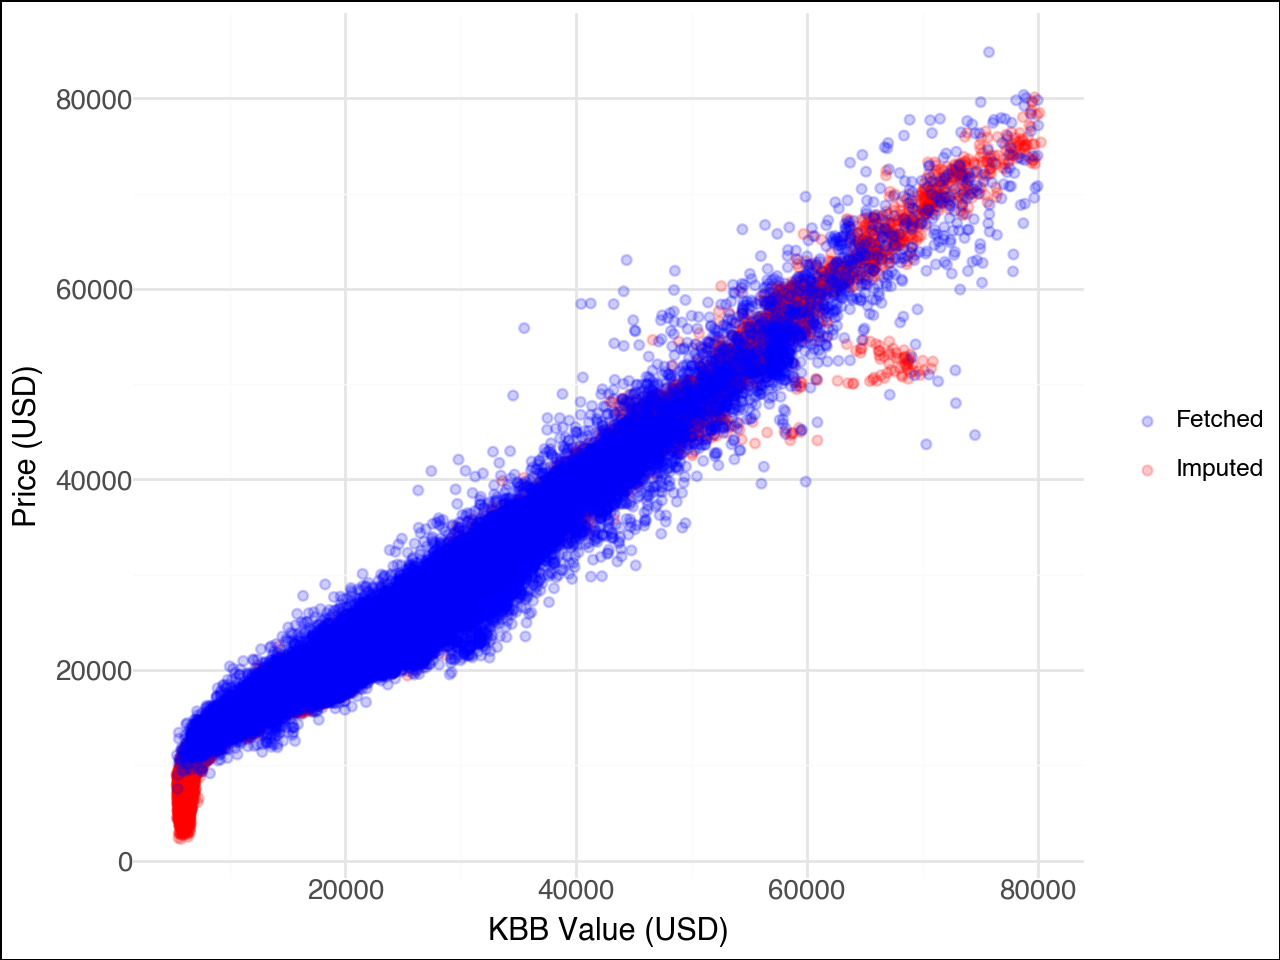

In [82]:
#Trial with lower alpha value
scatter_price_kbb = (
    ggplot(df.dropna(subset=["price_total", "price_kbbValue"]), aes(x="price_kbbValue", y="price_total", color="source")) +
    geom_jitter(alpha=0.2, width=500, height=500) +
    scale_color_manual(values={"Imputed": "red", "Fetched": "blue"}) +
    labs(x="KBB Value (USD)", y="Price (USD)") +
    theme_minimal() + plot_theme
)
scatter_price_kbb